<center><img src="../images/logo.png" alt="Your Image" style="width: 500px; height: auto"></center>

# Valuation of binary options via Neural Networks

In this notebook, we study the problem of pricing a binary option using a neural network model. The results are compared with values computed from the closed formula.


## Import

In [1]:
# import statements
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as si
import tensorflow as tf
from tensorflow.keras import backend, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split

%matplotlib inline

## Helper Functions

In [2]:
def plot_loss(history, iter_min = 0, iter_max = -1):
    """Plot loss during network training on training and validation data
    """
    plt.plot(history.history['loss'][iter_min:iter_max],'-x', label='training')
    plt.plot(history.history['val_loss'][iter_min:iter_max],'-x', label='validation')
    plt.legend()
    plt.yscale('log')
    plt.xlabel('#iterations')
    plt.ylabel('loss function value')
    plt.tight_layout()
    
def plot_loss_function(model, x, y, n_samples=30, random_state=42, start=-0.1, end=0.1, stepsize=0.001):
    """Plot projection of the network loss function along straight lines through the current network variables
    This method may be helpful to get an impression if the training has slowed down due 
    to a saddlepoint or maybe because a real local minima has been reached
    """
    np.random.seed(random_state)
    weights = [ np.copy(x) for x in model.get_weights() ]
    
    steps = np.arange(start,end,stepsize)
    loss_values = np.empty(steps.shape)
    for sample in range(n_samples):
        direction = []
        for w in weights:
            direction.append( np.random.uniform(0, 1, size = w.shape) )
        for i in range(steps.shape[0]):
            w = []
            for j in range(len(weights)):
                new_weights = np.copy(weights[j])
                new_weights += steps[i]*direction[j]
                w.append(new_weights)
            model.set_weights(w)
            loss_values[i] = model.evaluate(x,y, verbose=0)
        plt.plot(steps, loss_values)
    model.set_weights(weights)  
    plt.ylabel('loss')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.axvline(x=0.0)
      
def analyze_model(model, history, x, y):
    """This method plots the approximation errors on training and test data set.
    """
    print('Loss function on training data: '+ str(history.history['loss'][-1]))
    print('Loss function on validation data: '+ str(history.history['val_loss'][-1]))

    y_pred = model.predict(x).squeeze()
    
    plt.subplots(figsize=(25,12))
    plt.rcParams.update({'font.size': 18})
    plt.subplot(2,2,1)
    plot_loss(history)
    plt.legend()
    plt.tight_layout()    
    plt.subplot(2,2,2)
    plt.plot(x[:,0], y-y_pred, '.', label='y-y_pred')
    plt.xlabel('K')
    plt.ylabel('y-y_pred')
    plt.tight_layout()
    plt.subplot(2,2,3)
    plt.plot(x[:,1], y-y_pred, '.', label='y-y_pred')
    plt.xlabel('T')
    plt.ylabel('y-y_pred')
    plt.tight_layout()
    plt.subplot(2,2,4)
    plt.plot(x[:,1], y-y_pred, '.', label='y-y_pred')
    plt.xlabel('vol')
    plt.ylabel('y-y_pred')
    plt.tight_layout()

## Binary/digital options

We consider the case of a **cash or nothing CALL** binary option (cf., https://en.wikipedia.org/wiki/Binary_option):

A binary option is a financial exotic option in which the payoff is either some fixed monetary amount or nothing at all. In particular, a cash-or-nothing binary option pays some fixed amount of cash if the option expires in-the-money.

The price $C$ of a cash-or-nothing binary call option with maturity $T$, volatility $\sigma$, interest rate $r$ and strike $K$ is given by the equation

$$C=e^{-rT}N(d_2) $$

with 
$$ d_1 = \frac{1}{\sigma\sqrt{T}} \left( \ln \left( \frac{S}{K} \right) + \left( r + \frac{\sigma^2}{2} \right) T \right) 
\quad \text{and} \quad 
d_2 =  d_1 - \sigma\sqrt{T},$$

where $N(d)$ denotes the standard normal cumulative distribution function $$N(d) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^d e^{-z^2/2} dz.$$

### Generate and plot data

We create input data for the training of the neural network.

In [4]:
def cash_or_nothing_call(S, K, T, r, sigma):
    """ 
    Compute a call price 
    """

    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))  
    call = np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)

    return call

def create_data_example(n_points = 100, noise = False):
    """ 
    Returns:
    a matrix containing the strike, the time to maturity, the volatility, the strike and the call price
    in each column for 'n_points' number of rows
    """
    
    r = 0.0                                      # interest rate (not considered)    
    np.random.seed(42)                           # fix the initial seed to obtain reproducable results
    S = np.random.uniform(0.9,1.1, n_points)     # spot
    K = np.random.uniform(0.6,1.4, n_points)     # strike
    T = np.random.uniform(0.1,3.0, n_points)     # time to maturity
    vol = np.random.uniform(0.05, 1.5, n_points) # volatility
    result = np.empty((n_points, 5))
    for i in range(n_points):
        result[i,0] = K[i]
        result[i,1] = T[i]
        result[i,2] = vol[i]
        result[i,3] = S[i]
        result[i,4] = cash_or_nothing_call(S[i],K[i],T[i],r,vol[i]) 
        if noise == True:
            result[i,4] += 0.5*np.random.randn() # add N(0,1)-noise

    return result

The data set should be split in a training and a test set, because the quality of the method is not based on the error produced with the data used for training, but it is based on the potential for generalisation of the algorithm, that is, the performance on data not previously seen. In an extreme case, overfitting can happen, such that the results for the given data are very good, but new data does not achieve an acceptable outcome. To measure this, a part of the data set should not be used for training the data, but for testing the algorithm after the training procedure.

Here we create a data sample matrix with 5000 rows and use 80% as training data, while 20% are used for testing.


In [5]:
size = 5000
data = create_data_example(size)
x_train, x_test, y_train, y_test = train_test_split(data[:,0:-1], data[:,-1], test_size=0.2, random_state=42)

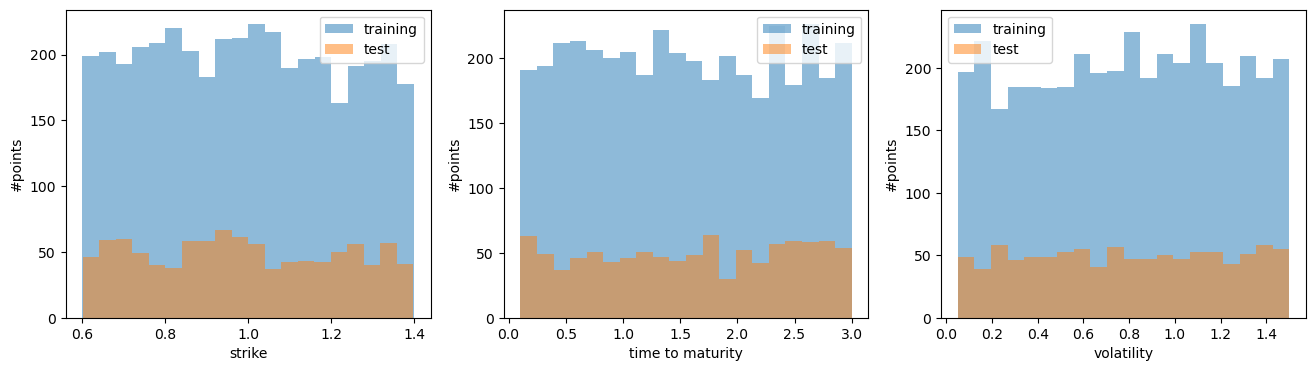

In [6]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.hist(x_train[:,0], bins=20, alpha=0.5, label='training')
plt.hist(x_test[:,0], bins=20, alpha=0.5, label='test')
plt.xlabel('strike')
plt.ylabel('#points')
plt.legend()

plt.subplot(1,3,2)
plt.hist(x_train[:,1], bins=20, alpha=0.5, label='training')
plt.hist(x_test[:,1], bins=20, alpha=0.5, label='test')
plt.xlabel('time to maturity')
plt.ylabel('#points')
plt.legend()

plt.subplot(1,3,3)
plt.hist(x_train[:,2], bins=20, alpha=0.5, label='training')
plt.hist(x_test[:,2], bins=20, alpha=0.5, label='test')
plt.xlabel('volatility')
plt.ylabel('#points');
plt.legend()

## Creating and Training the Neural Net

In this section, we build and train the neural net by using the *sequential* keras model for a simple multi-layer net in the function *create_simple_network*.
The function includes inner layers with the same activation function which can be specified and an output layer with a linear activation function.



In [7]:
def create_simple_network(n_neurons, activation='relu',
                           kernel_regularizer=None, bias_regularizer=None, input_dim=1):

    backend.clear_session()
    np.random.seed(42)
    model = Sequential()
    model.add(Dense(n_neurons[0], activation=activation, input_dim=input_dim, 
                    kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)) #input layer
    for n in n_neurons[1:]:
        model.add(Dense(n, activation=activation, kernel_regularizer=kernel_regularizer, 
                    bias_regularizer=bias_regularizer)) 
    model.add(Dense(1, activation='linear')) #output layer
    return model

We now establish the neural network model with 2 hidden layers with 20 neurons in the first hidden layer and 10 neurons in the second hidden layer. Moreover, we use the activation function *relu* for all neurons.
 

In [8]:
model = create_simple_network((20,10), 'elu', input_dim=x_train.shape[1])

The model can be examined by calling the summary method on the model.

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                100       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


### Training the Model

In this section, we train the neural net. The performance is significantly dependent on the optimizer, where the following two problems play a decisive role:
- The optimizer finds only a local minimum which does not produce satisfying results for the neural network.
- The optimizer converges very slowly, such that the user may wrongly assume that the minimum is reached without that being the case.

Thus, it is crucial which optimizer and parameters are used.

In [10]:
# Set a model checkpoint, i.e. during training the validation loss is checked and the model with best loss is saved
cb = []
#cb.append(callbacks.ModelCheckpoint('best_model.h5', save_best_only = True))

# Set callback to log training progress in tensorboard (may be commented out)
#log_dir = 'fit/logs/'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
#cb.append(callbacks.TensorBoard(profile_batch=0, log_dir=log_dir, histogram_freq=100))

In [21]:
# Load a pretrained model to save computation time, may be commented out
#model = keras.models.load_model('best_model.h5')

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='MSE')
# Fit the model
tf.random.set_seed(42) 
history = model.fit(x_train, y_train, epochs=1000, batch_size=100, verbose=0, callbacks=cb,
                    validation_split=0.2)

### Analysis of the Model

#### Training and Approximation Error

We plot the convergence history of the neural net and the point-wise error between the analytical and the approximative solution.

Loss function on training data: 7.148624717956409e-05
Loss function on validation data: 8.813699969323352e-05
125/125 [==============================] - 0s 657us/step


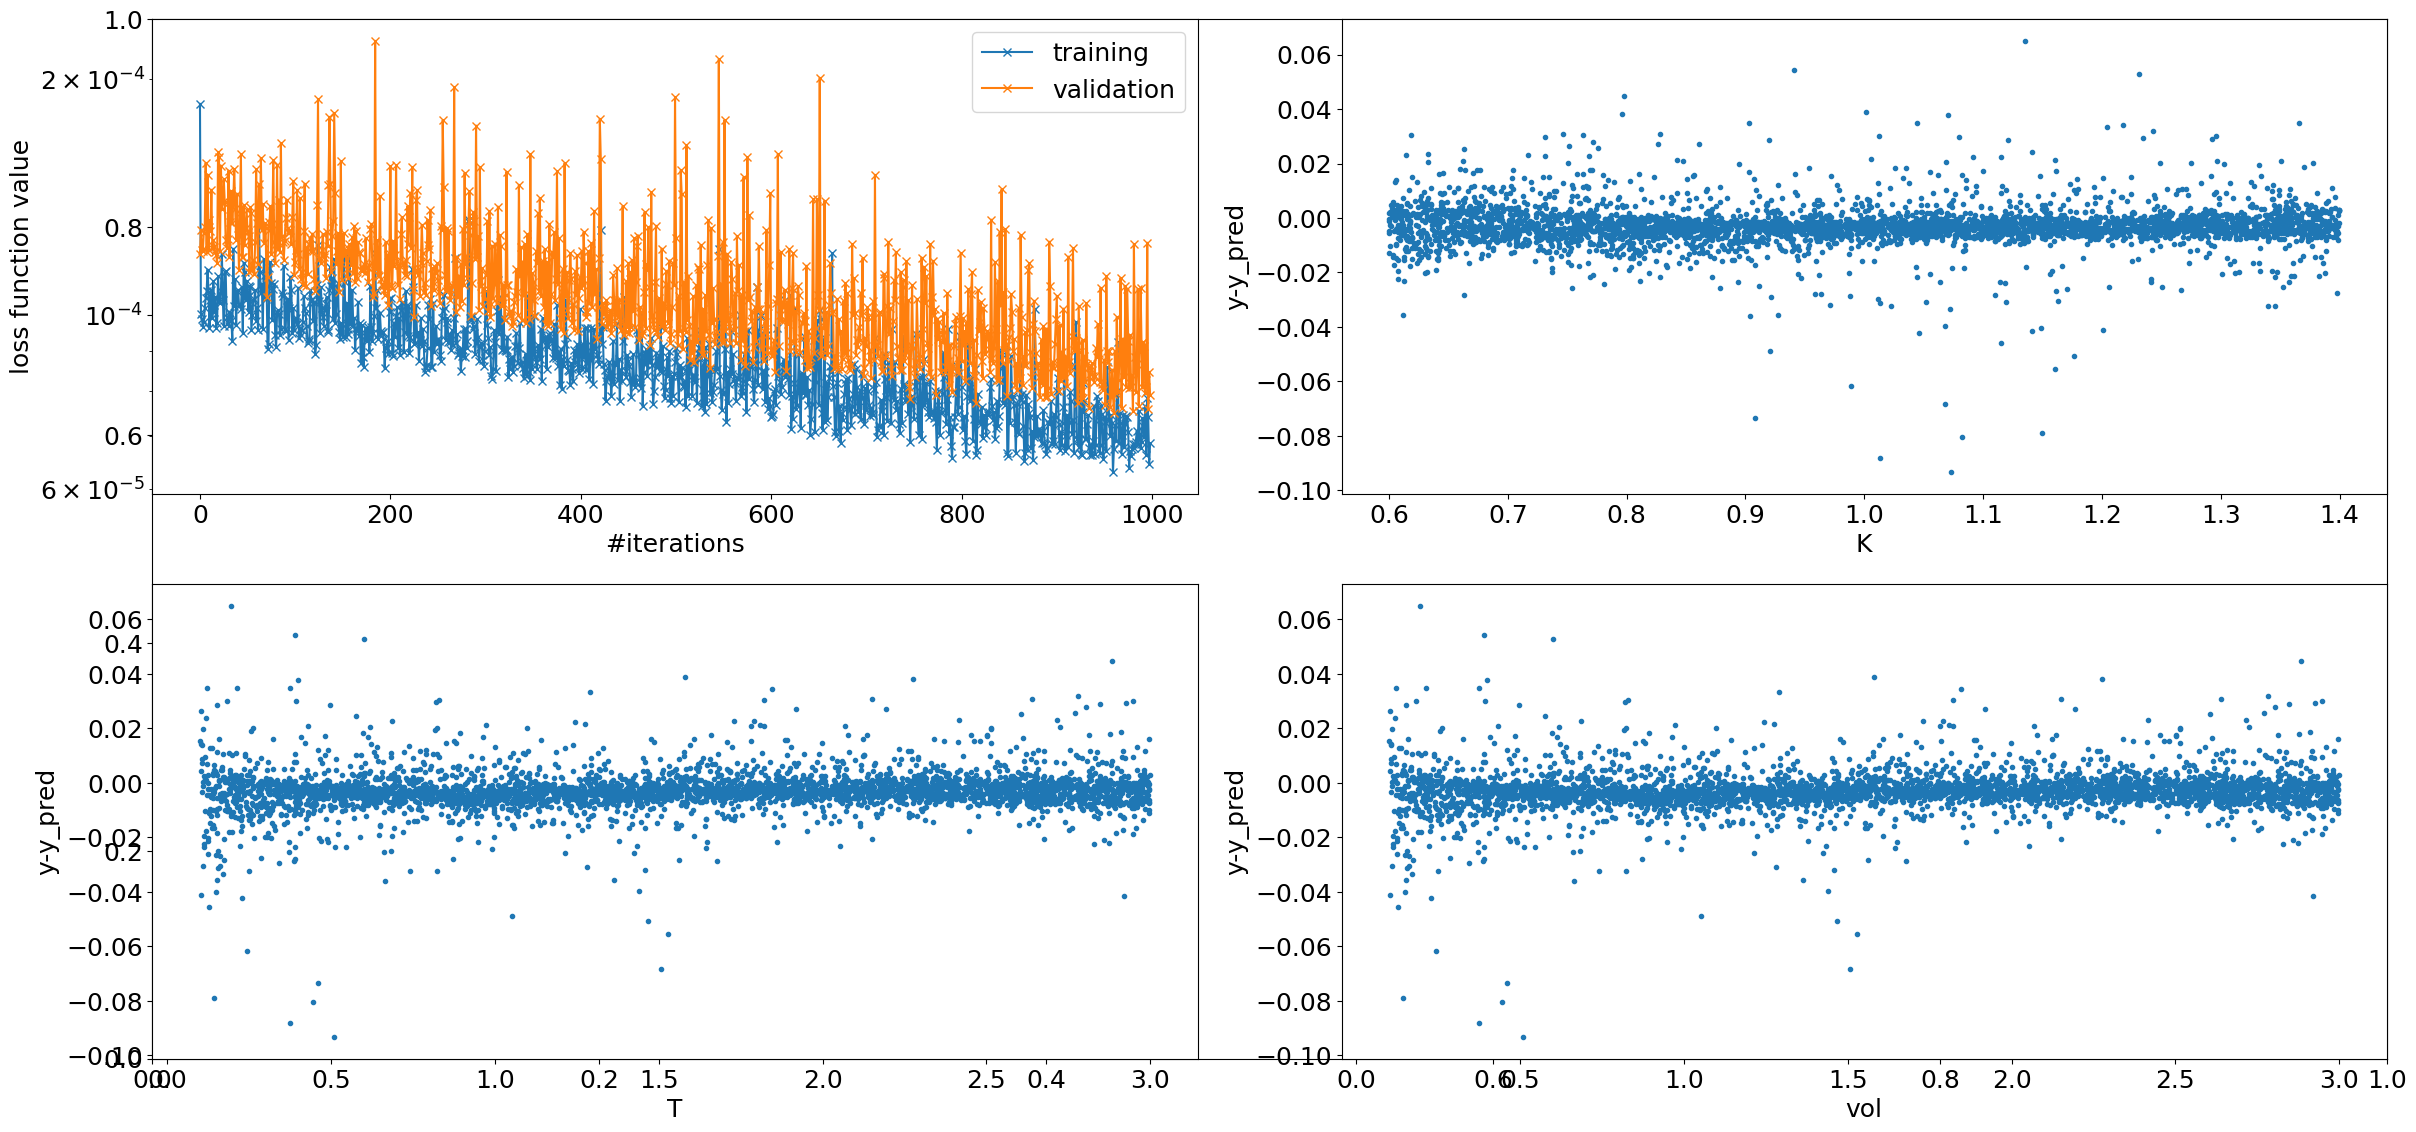

In [22]:
analyze_model(model, history, x_train, y_train)

Loss function on training data: 7.148624717956409e-05
Loss function on validation data: 8.813699969323352e-05
32/32 [==============================] - 0s 627us/step


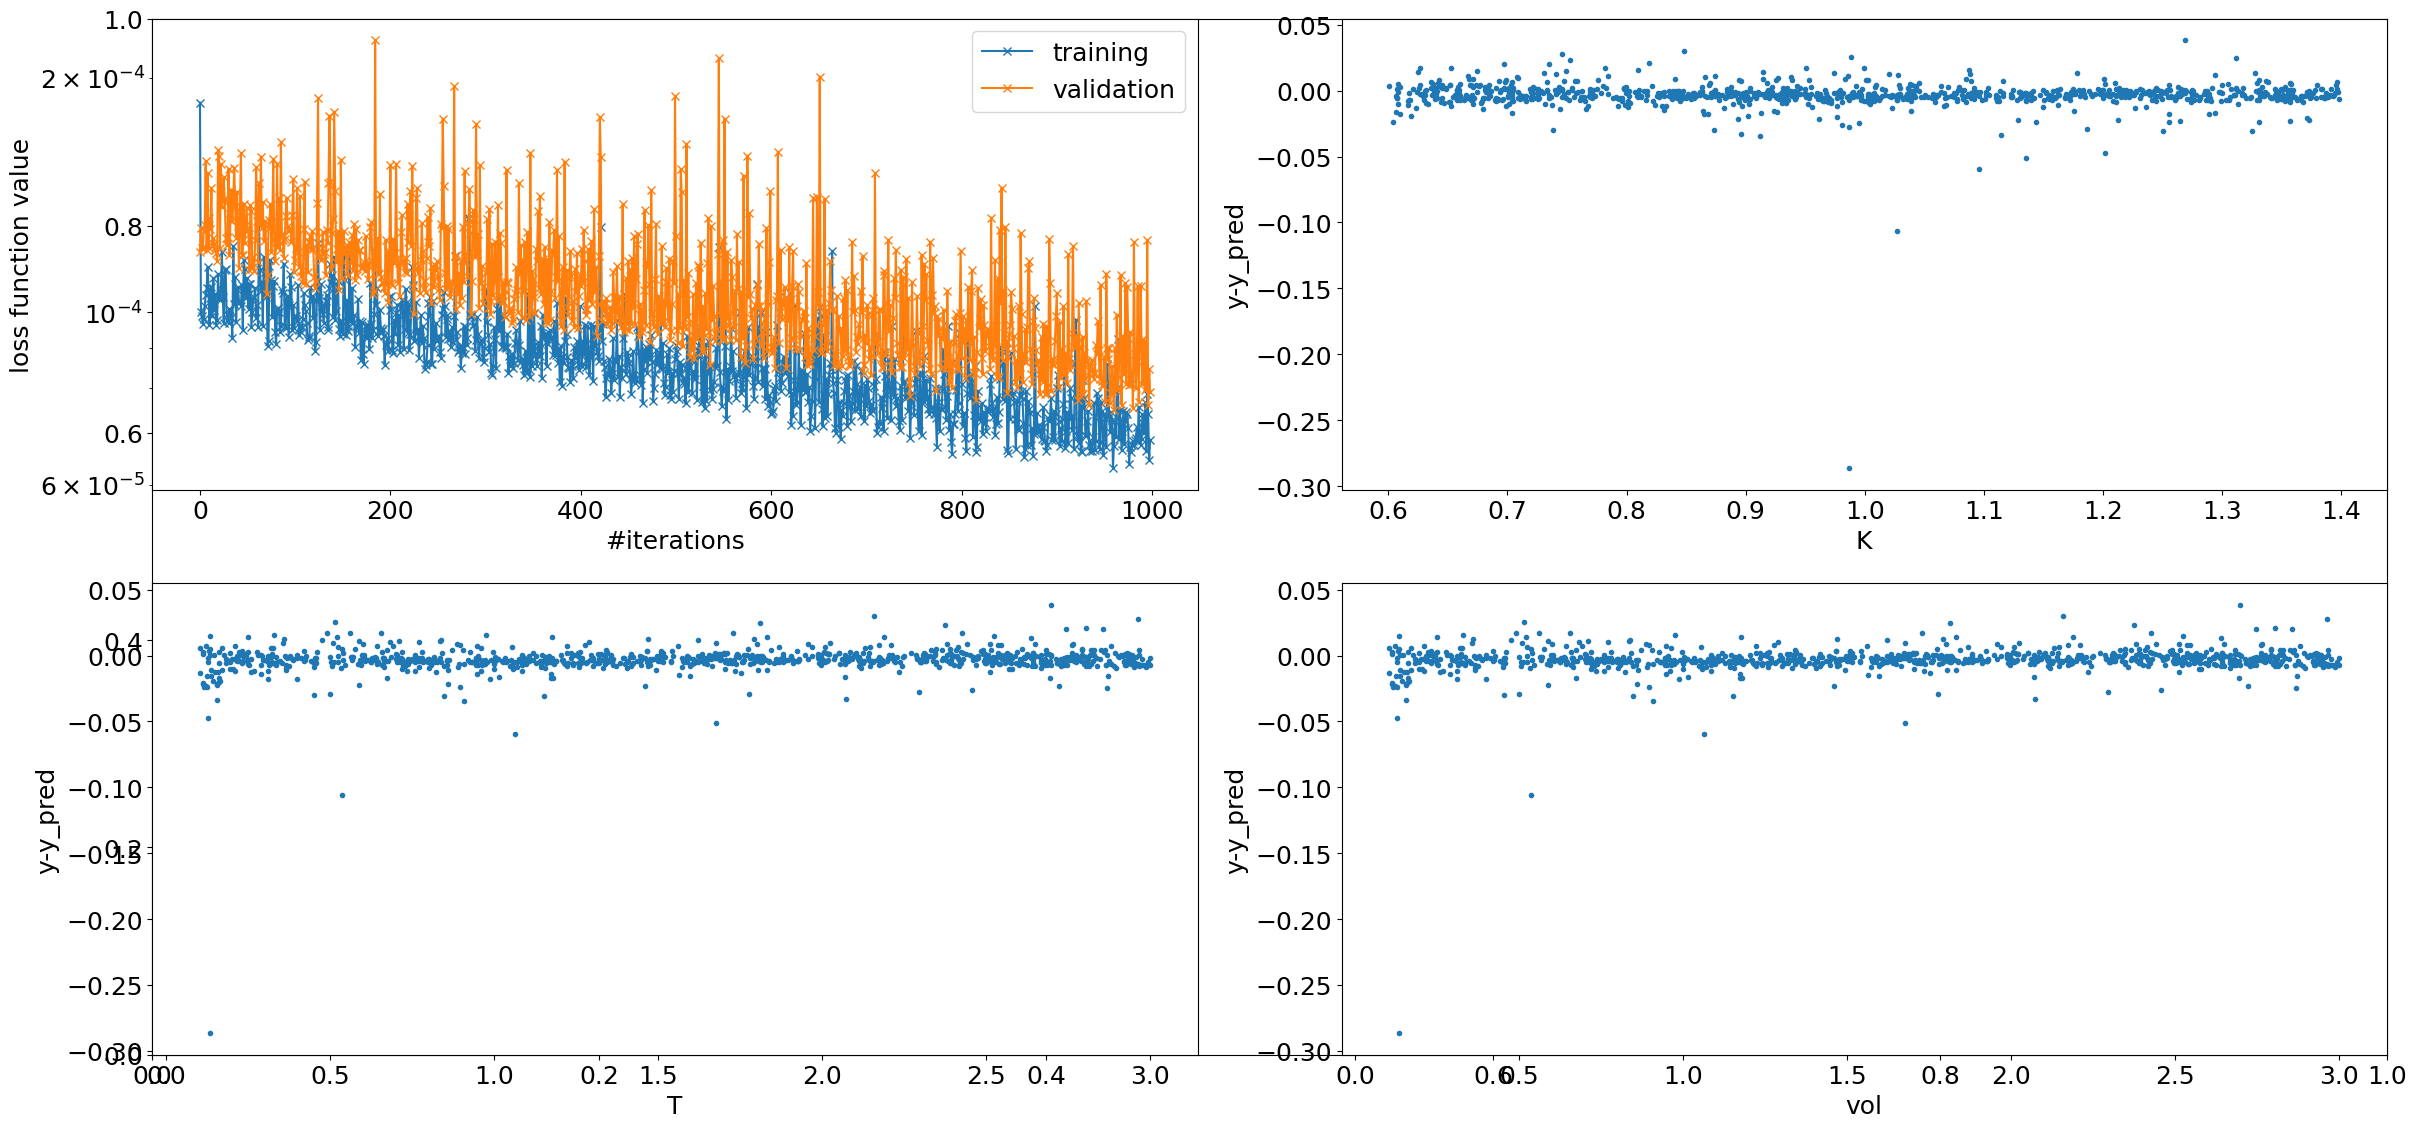

In [23]:
analyze_model(model, history, x_test, y_test)

#### Plotting the Loss Function

<div class="alert alert-block alert-danger">
The execution of the code in this section needs more computation time than the code in other sections.
</div>

To receive an impression of the training of the underlying minimisation problem and assess if the computed minimum is the correct solution, there exists the possibility to plot the cost functional in randomly sampled directions from the current point. One receives one-dimensional cuts of the high dimensional space (in different directions) which can also be plotted.
For the current problem, such plots are depicted in the images down below, while the cutout is reduced from left to right.

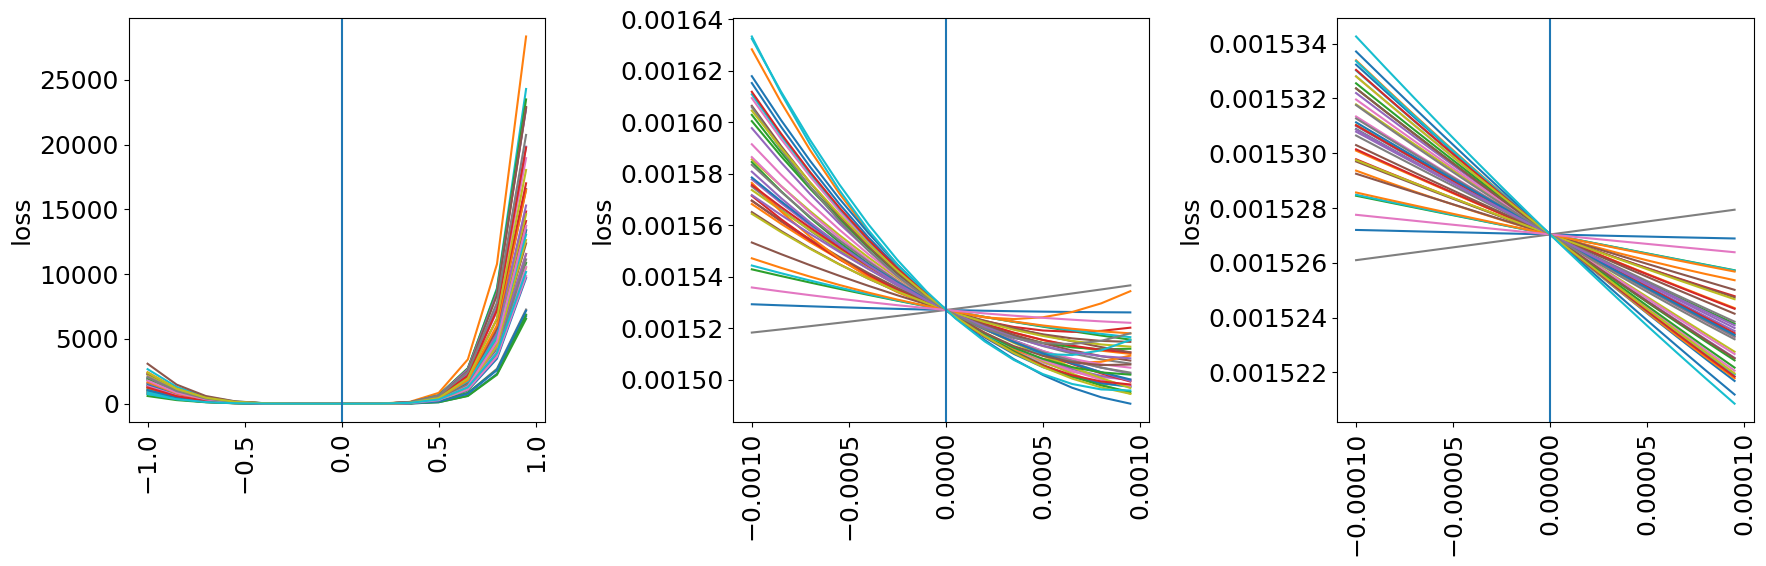

In [17]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plot_loss_function(model, x_train, y_train, n_samples=40, start = -1.0, end = 1.0, stepsize=0.15)

plt.subplot(1,3,2)
plot_loss_function(model, x_test, y_test, n_samples=40, start = -0.001, end = 0.001, stepsize=0.00015)

plt.subplot(1,3,3)
plot_loss_function(model, x_test, y_test, n_samples=40, start = -0.0001, end = 0.0001, stepsize=0.000015);

### Error Analysis

We compare the price with the results of the neural nets. 

In [24]:
# This function calculates the prices with respect to the input parameters 
# for the given model

def compute_price(x, model):
    x_ = Variable(x)
    y = model(x_, training=False)
    return y

In [25]:
def plot_errors(K, vol, T):
    S = np.linspace(0.8, 1.2, 50)
    x = np.empty((S.shape[0],4))
    x[:,0] = K
    x[:,1] = T
    x[:,2] = vol
    x[:,3] = S
    price= compute_price(x, model)
    
    fig = plt.figure(figsize=(18,6))
    price_bs = [cash_or_nothing_call(S[i], K, T, 0.0, vol) for i in range(S.shape[0])]
    plt.subplot(1,3,1)
    plt.plot(S, price,'-x', label='NN')
    plt.plot(S, price_bs,'-x', label='Closed Formula')
    plt.xlabel('spot')
    plt.ylabel('price')
    plt.legend()
    plt.tight_layout()
    


In [26]:
widgets.interact(plot_errors, 
                 K=widgets.FloatSlider(value=1.0, min=0.6,max=1.4, step=0.02, continuous_update=False), 
                 vol=widgets.FloatSlider(value=0.2, min=0.05, max=0.8, step=0.01, continuous_update=False), 
                 T=widgets.FloatSlider(value=1.0, min=10.0/365.0, max=3.0, step=30.0/365.0, continuous_update=False));

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='K', max=1.4, min=0.6, step=…